# Dimensionality reduction and clustering
##### 3rd April 2019, Bayes Building, University of Edinburgh

In [243]:
import pandas
import numpy as np

data = pandas.read_csv("Seattle_hourly_bikes.csv", index_col=0)

data.head()

,0,1,2,3,4,5,6,7,8,9,...,14.1,15.1,16.1,17.1,18.1,19.1,20.1,21.1,22.1,23.1
2012-10-03,9,6,1,3,1,10,50,95,146,104,...,77,72,133,192,122,59,29,25,24,5
2012-10-04,11,0,6,3,1,11,51,89,134,94,...,63,73,114,154,137,57,27,31,25,11
2012-10-05,7,4,3,2,2,7,37,101,119,81,...,63,80,120,144,107,42,27,11,10,16
2012-10-06,7,5,2,2,1,2,15,16,47,55,...,89,115,107,107,41,40,25,18,14,15
2012-10-07,5,5,1,2,2,3,8,12,26,36,...,126,122,132,118,68,26,19,12,9,5


### First, look at the data

In [41]:
# how many features? how many datapoints?
print(data.shape)

(2340, 48)


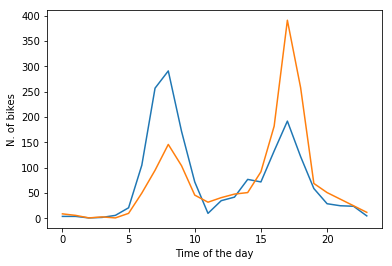

In [59]:
# how does a typical datapoint look like?

import matplotlib.pyplot as plt
%matplotlib inline

day0 = np.array(data.iloc[0])
plt.plot(day0[:24])
plt.plot(day0[24:])
plt.xlabel("Time of the day")
plt.ylabel("N. of bikes")

### Principal Component Analysis

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

reduced_data = pca.fit_transform(data)

In [27]:
# how many features now?
reduced_data.shape

(2340, 2)

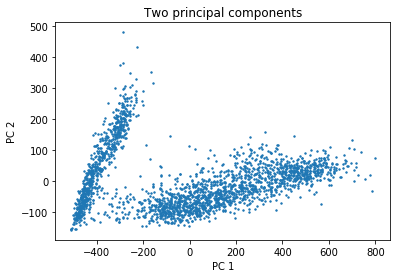

In [37]:
# now we can plot this


plt.title("Two principal components")
plt.scatter(reduced_data.T[0], reduced_data.T[1], s=2)
plt.xlabel("PC 1")
plt.ylabel("PC 2")

### How does it work?

![as](https://austingwalters.com/wp-content/uploads/2014/11/gaussDist-labeled.png)

PCA looks for the axis along which the data **varies** the most. In this case, the blue axis. Then, it looks for the second most "important" axis, under the constraint that it should be orthogonal to the first. And so on: although in this case we have only one other dimension, and the choice of the second axis is immediately clear.

The result of this whole operation is finding a new set of axes, such that each is orthogonal to the others (and so they can be used as a new coordinate system). We can then **transform** the original variables into new ones, which are the new coordinates. These new variables are:
- linearly independent (uncorrelated);
- ranked from the one with largest variance to the one with smallest variance.
Because of the second condition, we can remove variables with low variance, and keep the ones with large variance, which are called **principal components**.

Mathematically, this whole thing is done by:
- computing the covariance matrix of the data
- finding its eigenvectors and sorting them from largest to smallest eigenvalue
- transforming the data into the basis given by eigenvectors.

### Interpreting what the principal components represent

Hypothesis: the total number of bikes passing is an important factor

In [33]:
total_per_day = data.sum(axis=1)

total_per_day.shape

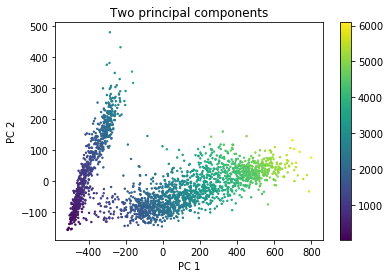

In [40]:
# repeat the same plot

plt.title("Two principal components")
plt.scatter(reduced_data.T[0], reduced_data.T[1], s=2, c=total_per_day)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar()

This is insufficient. Then, what we need to do is look at the typical structure of days in the first group versus days in the second group. But to do so, we actually need to find out *a way to separate the two groups*. This is called *clustering*, and is an example of unsupervised learning: we don't have labels. The solution is not known. We only rely on the structure of the data.

# Clustering


In [139]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2)
cluster_assignment = gmm.fit_predict(data)

In [147]:
cluster0_content = reduced_data[cluster_assignment == 0]
cluster1_content = reduced_data[cluster_assignment == 1]

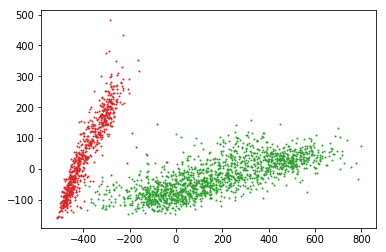

In [208]:
plt.scatter(cluster0_content[:,0], cluster0_content[:,1], s=1, c='C2')
plt.scatter(cluster1_content[:,0], cluster1_content[:,1], s=1, c='C3')

In [164]:
mean_daily_profile0 = np.mean(data.iloc[cluster_assignment == 0], axis=0)
mean_daily_profile1 = np.mean(data.iloc[cluster_assignment == 1], axis=0)

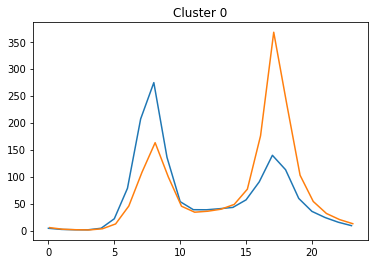

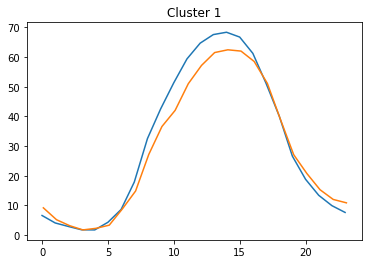

In [169]:
plt.figure()
plt.title("Cluster 0")
plt.plot(mean_daily_profile0[:24])
plt.plot(mean_daily_profile0[24:])

plt.figure()
plt.title("Cluster 1")
plt.plot(mean_daily_profile1[:24])
plt.plot(mean_daily_profile1[24:])

### The solution to our conundrum

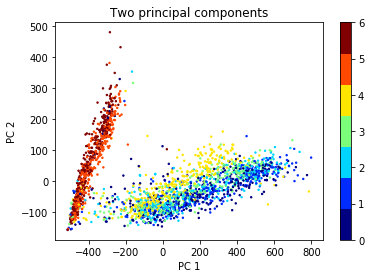

In [178]:
dayofweek = pandas.to_datetime(data.index).dayofweek

plt.title("Two principal components")
plt.scatter(reduced_data.T[0], reduced_data.T[1], s=2,
            c=dayofweek, cmap=plt.cm.get_cmap('jet', 7))
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar()

# Part two: implementing k-means from scratch

K-Means is one of the most popular clustering algorithms. It's not too reliable, as it works well only with well-separated and reasonably-shaped clusters. However, it's a good example of an algorithm that can be taught in all its detail and implemented from scratch.

### The k-means algorithm

If I know in advance I want to find *k* clusters:
- Pick *k* random cluster centers;
- Assign every point to the cluster defined by the **nearest** center;
- Update the cluster centres: they are the average of points in a cluster;
- Iterate until convergence (or for a fixed number of iterations).

![ala](https://upload.wikimedia.org/wikipedia/commons/e/ea/K-means_convergence.gif)

In [227]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000, centers=5)

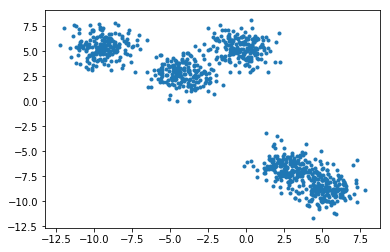

In [228]:
#blobs
plt.plot(X[:,0], X[:, 1], '.')

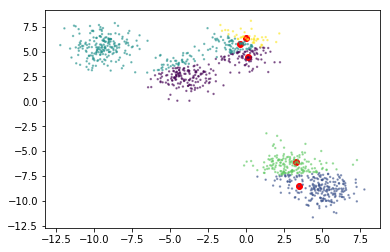

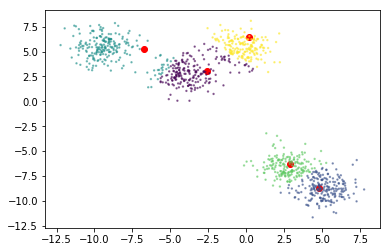

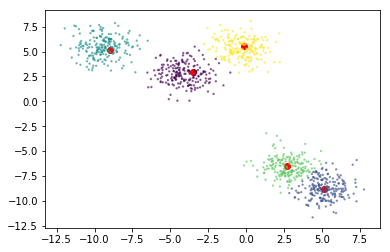

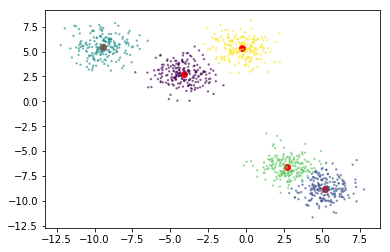

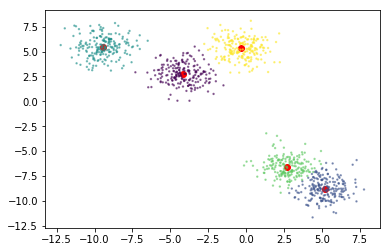

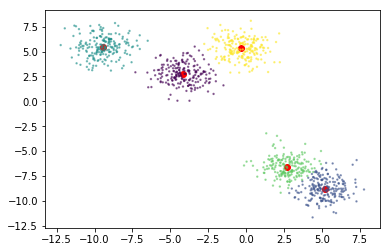

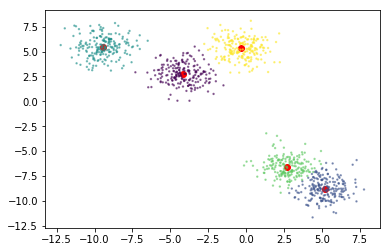

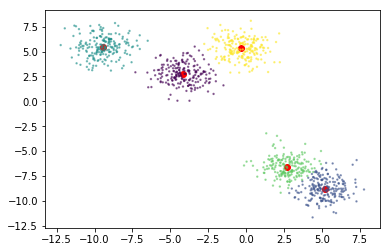

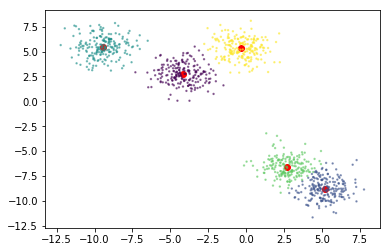

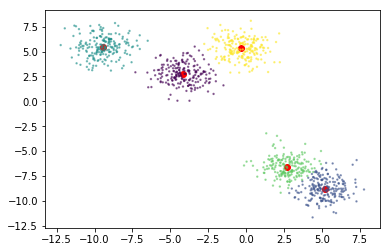

In [229]:
k = 5
n_iter = 10
dataset = X
# randomly pick k centres
random_indices = np.random.choice(len(dataset), size=k)
centres = dataset[random_indices]
for i in range(n_iter):
    plt.figure()
    plt.scatter(*centres.T, c='r')
    # for each point, find the nearest centre
    distances = ((dataset[:, np.newaxis] - centres)**2).mean(axis=2)
    nearest_centre_index = np.argmin(distances, axis=1)
    plt.scatter(*dataset.T, s=2, c=nearest_centre_index, alpha=.5)
    # update centres
    for c in range(k):
        centres[c] = np.mean(dataset[nearest_centre_index == c], axis=0)